# Logisitic Regression

This models the probability of a binary outcome on a numerical ordinal control variable. The model proposes that the probability strictly increases (decreases) with increasing values of the numerical ordinal control variable.

Sometimes our binary outcome data comes to us as sparse results, that is individual true or false outcomes. For example, outcomes of a clinical study, where the symptom was alleviated or did not. In other circumstances we will have aggregate data from a binary process (Bernoulli process), that we will have to coerce into a shape to which we can apply logistic regression.

In our example we will use total births per country per year, this is the number of coin flips, and the early childhood mortality rate, average outcomes of the coin flips. We will regress this against our GDP disparity.

* [UN, World Population Prospects (2022) – processed by Our World in Data. “Births”](https://ourworldindata.org/grapher/annual-number-of-births-by-world-region)
* [UN, World Population Prospects (2022) – processed by Our World in Data. “Deaths - Sex: all - Age: all - Variant: estimates”](https://ourworldindata.org/grapher/number-of-deaths-per-year)

In [5]:
# The usual suspects.
# %matplotlib widget
import pandas as pd
import matplotlib.pyplot as mp
from sklearn.linear_model import LogisticRegression as lr
import numpy as np
import ipywidgets as wg

## Diagnosing Logisitic Regression

Plan of attack:
1. Plot the sigmoid or expit function
2. Generate uniform random control
3. Generate logistic sample from random control
4. Do logistic regression
5. Add sliders to filter the control variable
6. Redraw the regression.

Similar to the SciKit-Learn documentation our sigmoid or expit function is:
$$
expit(x) = \frac{1}{1 - \operatorname{e}^{-(ax+b)}}
$$

In [2]:
# Sigmoid or expit function
def expit(x, a = 1, b = 0):
    return 1 / (1 + np.exp(-(a*x + b)))

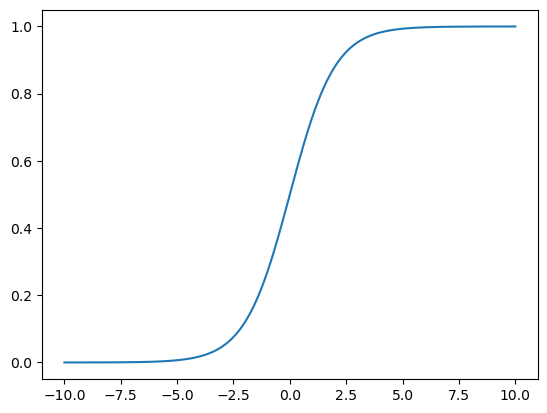

interactive(children=(FloatSlider(value=1.0, description='a', max=10.0), FloatSlider(value=0.0, description='b…

<function __main__.redraw(a=1, b=0)>

In [3]:
# X-axis ticks. These are the control or independent data
xticks = np.linspace(-10, 10, 2000)

# Blank canvas
logisticfig, logisticaxis = mp.subplots()

# Individual curves
expitcurve, = logisticaxis.plot(xticks, expit(xticks))

# Redraw commands
def redraw(a = 1, b = 0):
    expitcurve.set_ydata(expit(xticks, a, b))
    logisticfig.canvas.draw_idle()

# Illustrate
wg.interact(redraw, a = (0, 10, 0.1), b = (-4, 4, 0.1))

## Poor Sampling

To illustrate the impact of poor sampling in the region of classification equivocation we
will generate some random observations from a logistic process centered on $0$ and then
exclude points around zero.

In this figure we have the following components:
* The blue line is the slope through the region of exclusion.
* The orange line is the actual logistic process.
* The green line is the estimated logistic process.
* The tick marks are the observations that were not excluded.
* The text indicates the slope through the exclusion region, the estimated coefficient
(slope), and the estimated center.

Note that as we increase the the size of the exclusion area the estimated slope exceeds the
slope through the exclusion region, and the center becomes sensitive to the samples and the
boundaries of the exclusion region.

The estimated slope exceeding the slope through the exclusion area is indicative of poor
data sampling.

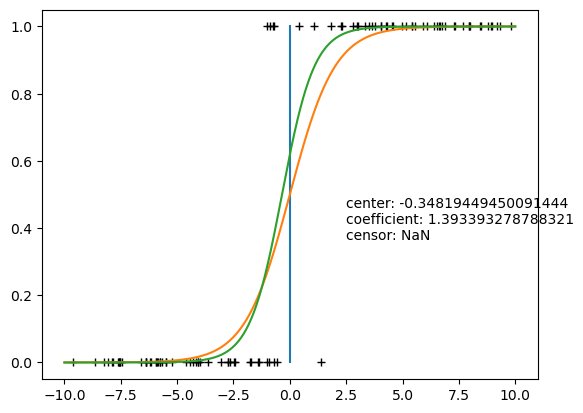

interactive(children=(FloatSlider(value=0.0, description='c', max=5.0), Output()), _dom_classes=('widget-inter…

<function __main__.redrawsimulation(c=0)>

In [6]:
# Simulate 100 random values of the control
samples = 10**2
control = np.random.uniform(-10, 10, samples)
response = np.random.uniform(0, 1, samples) < expit(control)
response.astype(float)

# Fit a logistic regress model
estimator = lr(penalty = None).fit(
    X = control.reshape(-1, 1),
    y = response
)

# Blank canvas
estimatefig, estimateaxis = mp.subplots()

# Individual curves
censorcurve, = estimateaxis.plot([ 0, 0 ], [ 0, 1 ])
samplecurve, = estimateaxis.plot(control, response, "+k")
actualcurve, = estimateaxis.plot(xticks, expit(xticks))
estimatecurve, = estimateaxis.plot(
    xticks,
    estimator.predict_proba(xticks.reshape(-1, 1))[:, 1]
)
coefficients = estimatefig.text(
    0.6,
    0.4,
    f"center: {-estimator.intercept_[0]/estimator.coef_[0,0]}\ncoefficient: {estimator.coef_[0,0]}\ncensor: NaN"
)

# Redraw filtering out the samples around the origin to a width of "c"
def redrawsimulation(c = 0):
    X = control[abs(control) >= c]
    Y = response[abs(control) >= c].astype(float)
    censorcurve.set_data([ -c, c ], [ 0, 1 ])
    samplecurve.set_data(X, Y)
    estimator.fit(
        X = X.reshape(-1, 1),
        y = Y
    )
    estimatecurve.set_ydata(estimator.predict_proba(xticks.reshape(-1, 1))[:, 1])
    if c > 0:
        slope = 1 / (2 * c)
    else:
        slope = "NaN"
    coefficients.set_text(
        f"center: {-estimator.intercept_[0]/estimator.coef_[0,0]}\ncoefficient: {estimator.coef_[0,0]}\ncensor: {slope}"
    )
    logisticfig.canvas.draw_idle()

# # Illustrate
wg.interact(redrawsimulation, c= (0, 5, 0.1))